In [1]:
import os
os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd 
import capacity.utils.sim_block_diag as sim
import scienceplots

plt.style.use('science')

In [3]:
# format data
df = pd.read_csv(os.getcwd() + '/results/clouds/gauss_cloud.csv', index_col=0)
mdf = df.groupby('intensity').mean().reset_index()
stdf= df.groupby('intensity').std().reset_index()

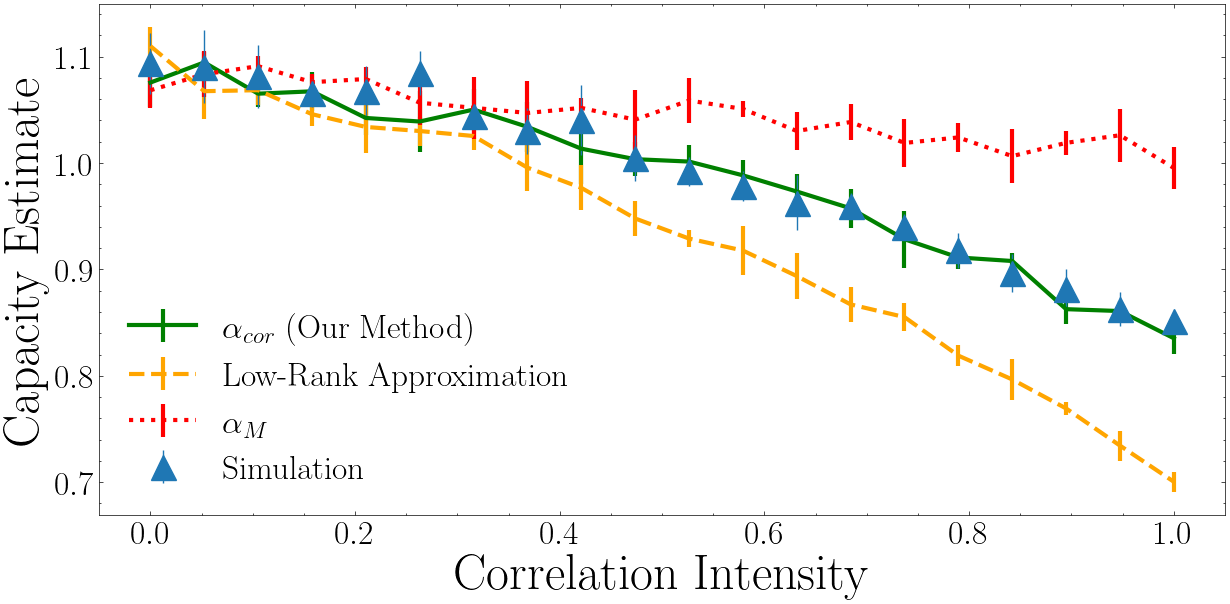

In [4]:
fig,axs=plt.subplots(figsize=(12.5, 1/2 * 12.5))
fn = 36
### comparison 
lw=3
ms=18
axs.errorbar(mdf.intensity, mdf.alpha_rep, yerr=stdf.alpha_rep, label = r'$\alpha_{cor}$ (Our Method)', lw=lw, color='green')
axs.errorbar(mdf.intensity, mdf.alpha_nc, yerr=stdf.alpha_nc, label = 'Low-Rank Approximation', linestyle = '--',lw=lw, color='orange')
axs.errorbar(mdf.intensity, mdf.alpha_mf, yerr=stdf.alpha_mf, label = r'$\alpha_{M}$', linestyle = ':',lw=lw, color='red')
axs.errorbar(mdf.intensity, mdf.alpha_sim, yerr=stdf.alpha_sim,  ls='', marker='^', label = 'Simulation', color='#1f77b4', markersize=ms)


axs.legend(fontsize=fn * 2/3)
axs.set_xlabel('Correlation Intensity', fontsize=fn) 
axs.set_ylabel('Capacity Estimate', fontsize=fn)
axs.tick_params(labelsize=fn*2/3)
plt.tight_layout()
plt.savefig(os.getcwd() + '/results/clouds/smol-clouds.eps', dpi=300, format='eps', bbox_inches='tight', pad_inches=0.15)
plt.show()

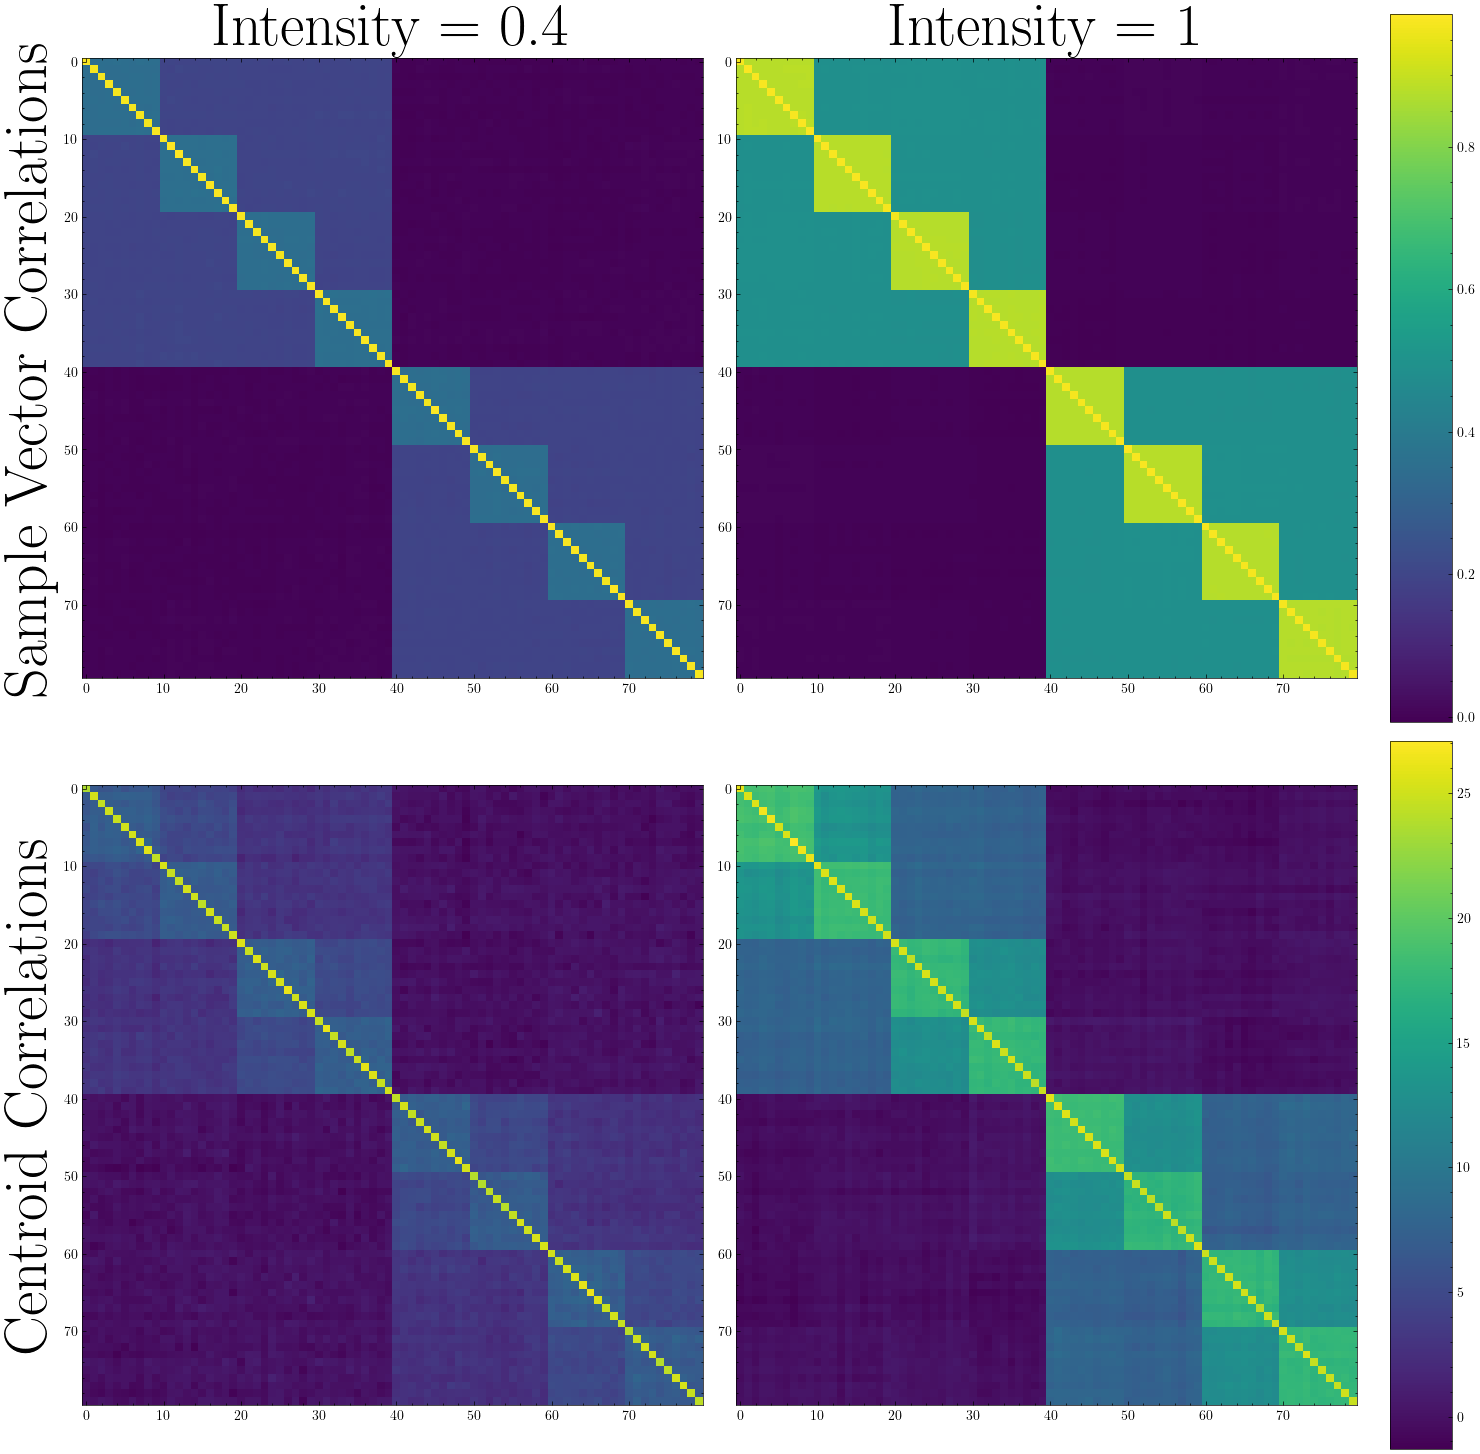

In [5]:
# make the Supplementary fig 
### Configure cloud simulation and figure params
fn = 36 * 15/12.5 #fontsize
scale = 1.

P, N, samples = 80, 3800, 40
intensities = [.4, 1]
level_sizes_cent = [2, 2, 2]
corrs_cent = np.array([0, 0.3, 0.5, 0.7])
level_sizes_pt = [2, 4]
corrs_pt = np.array([0.0, 0.5, 0.9])

## first one
cloud = sim.gaussian_clouds(P, N, samples, level_sizes_cent,
                                  intensities[0]*corrs_cent, level_sizes_pt, intensities[0]*corrs_pt, radius=1.,
                                    center_radius=5.)
cents = cloud.mean(1, keepdims=False) 
cov_low = cents @ cents.T
axs = cloud - cloud.mean(1, keepdims=True)
cova_low = np.einsum('ijk, ljk -> il', axs, axs) / samples

### second one 
cloud = sim.gaussian_clouds(P, N, samples, level_sizes_cent,
                                  intensities[1]*corrs_cent, level_sizes_pt, intensities[1]*corrs_pt, radius=1.,
                                    center_radius=5.)
cents = cloud.mean(1, keepdims=False) 
cov_high = cents @ cents.T
axs = cloud - cloud.mean(1, keepdims=True)
cova_high = np.einsum('ijk, ljk -> il', axs, axs) / samples

### make figs and cbars

fig, axs = plt.subplot_mosaic([['a)', 'b)', 'bar)'], ['c)', 'd)', 'bar2)']],
                              constrained_layout=False, 
                              figsize= (15*scale,15*scale),
                             gridspec_kw = {'width_ratios' : [1,1,0.1]})

# get the mins and maxes to use the same cbar across imgs 
vmina, vmaxa = np.min(np.stack([cova_low,cova_high])), np.max(np.stack([cova_low,cova_high]))
vminc, vmaxc = np.min(np.stack([cov_low,cov_high])), np.max(np.stack([cov_low,cov_high]))

aim = axs['a)'].imshow(cova_low, vmin=vmina, vmax=vmaxa) 
aim = axs['b)'].imshow(cova_high, vmin=vmina, vmax=vmaxa)
cim = axs['c)'].imshow(cov_low, vmin=vminc, vmax=vmaxc)
cim = axs['d)'].imshow(cov_high, vmin=vminc, vmax=vmaxc)

plt.colorbar(aim, cax=axs['bar)'])
plt.colorbar(cim, cax=axs['bar2)'])

axs['a)'].set_title(f'Intensity = {intensities[0]}', fontsize=fn)
axs['b)'].set_title(f'Intensity = {intensities[1]}', fontsize=fn)

axs['a)'].set_ylabel('Sample Vector Correlations',fontsize=fn)
axs['c)'].set_ylabel('Centroid Correlations', fontsize=fn)
    
plt.tight_layout() 
fig.savefig(os.getcwd() + '/results/clouds/sm-covs.eps', format='eps', dpi=300)